In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle

from beerai.config import DATA_DIR

In [2]:
%matplotlib inline

In [3]:
with pd.HDFStore(os.path.join(DATA_DIR, "interim/all_recipes.h5")) as store:
    core = store.get("core")
    ings = store.get("ingredients")

In [4]:
core.head()

,batch_size,boil_size,boil_time,brewer,efficiency,name,origin,recipe_file,src_abv,src_color,src_fg,src_ibu,src_og,style_category,style_guide,style_name,style_version
id,,,,,,,,,,,,,,,,,
0,18.927059,21.198306,60.0,velkyal,0.75,dark island oir leann,brewtoad,recipes/brewtoad/dark-island-oir-leann.xml,NaN,NaN,NaN,NaN,NaN,6b,bjcp,blonde ale,1.0
1,22.712471,28.390588,60.0,wain thor,0.85,witbur,brewtoad,recipes/brewtoad/witbur.xml,NaN,NaN,NaN,NaN,NaN,6d,bjcp,american wheat or rye beer,1.0
2,20.819765,24.983718,60.0,btfielder,0.75,kolsch,brewtoad,recipes/brewtoad/kolsch-9285a4.xml,NaN,NaN,NaN,NaN,NaN,6c,bjcp,kölsch,1.0
3,18.927059,23.658824,60.0,viff brewing,0.75,amber alert,brewtoad,recipes/brewtoad/amber-alert-4.xml,NaN,NaN,NaN,NaN,NaN,10b,bjcp,american amber ale,1.0
4,18.927059,23.658824,60.0,pistolpete2,0.75,graff,brewtoad,recipes/brewtoad/graff-14.xml,NaN,NaN,NaN,NaN,NaN,20a,bjcp,fruit beer,1.0


In [5]:
map_files = glob.glob(os.path.join(DATA_DIR, "interim/*map.pickle"))
map_files = {os.path.basename(m)[:-10]: m for m in map_files}

maps = {}
for label, map_file in map_files.items():
    with open(map_file, "rb") as f:
        maps[label] = pickle.load(f)

In [6]:
ings["ferm_name"] = ings["ferm_name"].map(maps["ferm"])
ings["hop_name"] = ings["hop_name"].map(maps["hop"])
ings["yeast_name"] = ings["yeast_name"].map(maps["yeast"])
ings["misc_name"] = ings["misc_name"].map(maps["misc"])

In [7]:
styles = ["robust porter", "american stout"]

In [8]:
recipe_ids = core[core["style_name"].isin(styles)].index

In [9]:
stouts =  core.loc[recipe_ids].join(ings, how="left")

In [10]:
stouts.index.nunique()

16895

# First Go

Let's just start by counting the fermentables and normalizing

In [ ]:
rp = stouts[stouts.style_name == "robust porter"].ferm_name.value_counts(normalize=True)
rp.name = "robust porter"
rp = pd.DataFrame(rp)

In [12]:
ast = stouts[stouts.style_name == "american stout"].ferm_name.value_counts(normalize=True)
ast.name = "american stout"
ast = pd.DataFrame(ast)

In [13]:
stout_ferms = rp.join(ast, how="outer")

In [14]:
stout_ferms["tot"] = stout_ferms.sum(axis=1)
stout_ferms = stout_ferms.sort_values("tot")

In [15]:
stout_ferms = stout_ferms.tail(20)
stout_ferms

,robust porter,american stout,tot
white wheat,0.011574,0.011574,0.023148
brown malt,0.018876,0.005022,0.023898
special b,0.014662,0.009924,0.024586
pale chocolate,0.014157,0.011885,0.026042
munich malt,0.021401,0.008561,0.029961
liquid malt extract - light,0.017847,0.013415,0.031262
dry malt extract - light,0.017944,0.014802,0.032746
flaked barley,0.013380,0.026615,0.039996
carapils® malt,0.025828,0.019657,0.045485
caramel malt 40l,0.033266,0.021163,0.054429


<AxesSubplot:>

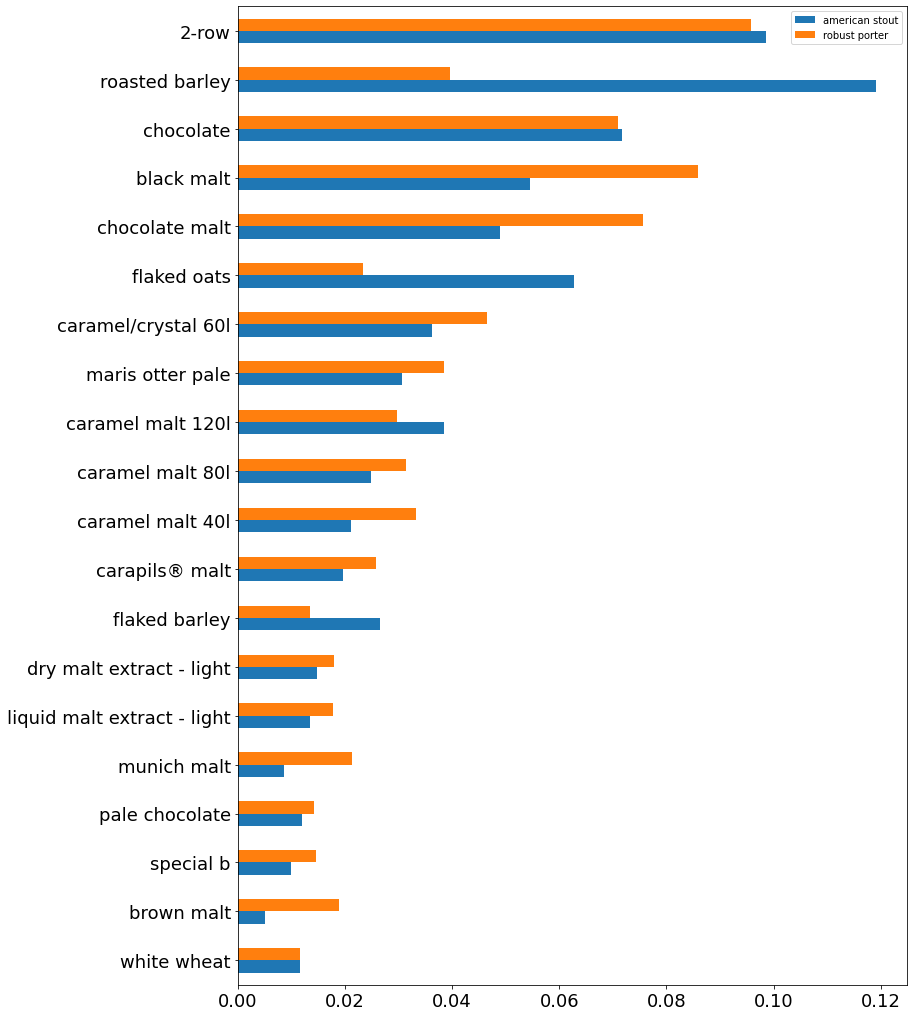

In [16]:
stout_ferms[["american stout", "robust porter"]].plot(kind="barh", stacked=False, figsize=(12,18), fontsize=18)

# Adjust for Mass

The above calculation simply adds "1" for each appearance of a fermentable, regardless of how much of the fermentable is added, and would add multiple if it appeared in the recipe multiple times. What would likely be better would be to look at the percentage of the grain bill for each fermentable.

In [30]:
by_style_ferm = stouts.groupby(["style_name", "ferm_name"]).ferm_amount.sum()
by_style = stouts.groupby(["style_name"]).ferm_amount.sum()
average_bill = by_style_ferm / by_style
average_bill

style_name      ferm_name                          
american stout  2-row                                  0.428363
                6-row                                  0.004346
                abbey malt                             0.000070
                acidulated malt                        0.000102
                amber malt                             0.000907
                                                         ...   
robust porter   victory® malt                          0.004919
                vienna                                 0.004128
                warminster floor-malted maris otter    0.002538
                wheat, red                             0.000065
                white wheat                            0.005850
Name: ferm_amount, Length: 242, dtype: float64

In [53]:
average_bill = average_bill.reset_index()

In [63]:
ferms_by_mass = average_bill.pivot_table(index="ferm_name", columns="style_name", dropna=False)

In [69]:
ferms_by_mass.columns = ferms_by_mass.columns.droplevel()

In [86]:
ferms_by_mass["tot"] = ferms_by_mass.sum(axis=1)
ferms_by_mass["dif"] = ferms_by_mass["american stout"] - ferms_by_mass["robust porter"]
ferms_by_mass["absdif"] = (ferms_by_mass["american stout"] - ferms_by_mass["robust porter"]).abs()

In [88]:
ferms_by_mass = ferms_by_mass.sort_values("absdif")

<AxesSubplot:ylabel='ferm_name'>

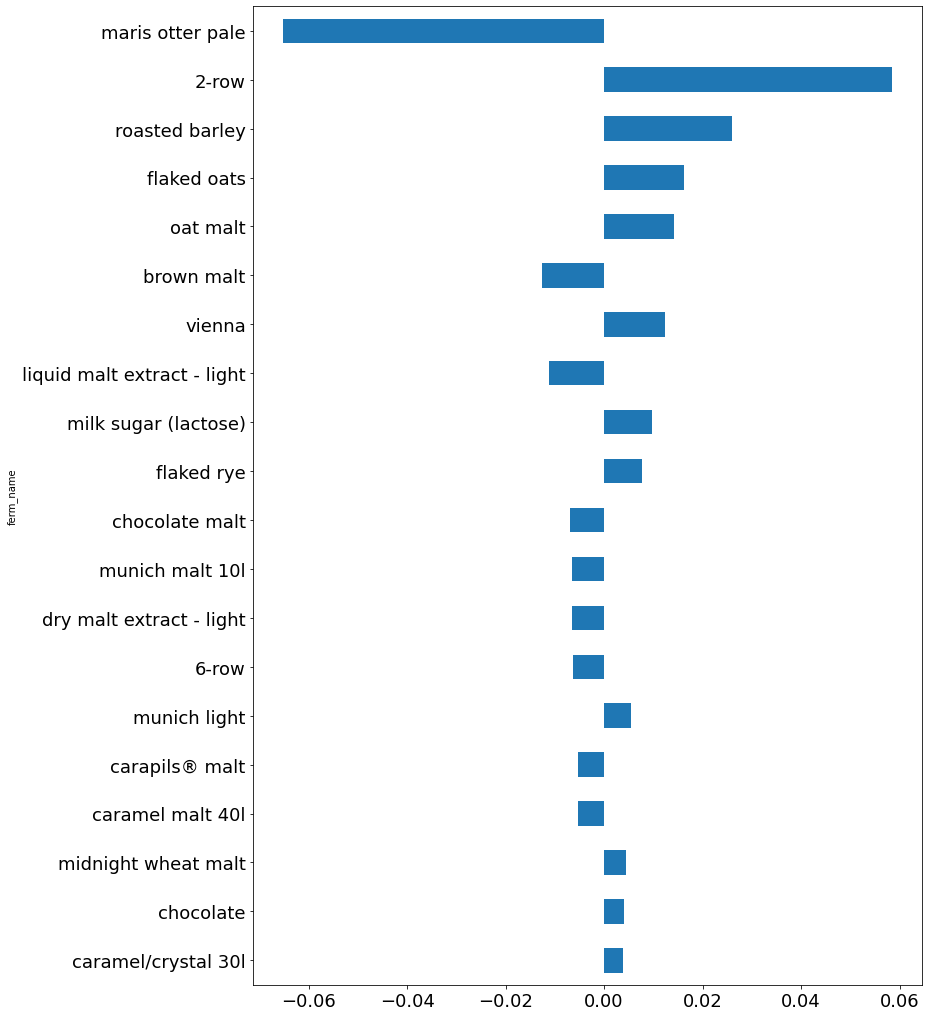

In [93]:
ferms_by_mass["dif"].iloc[-20:].plot(kind="barh", stacked=False, figsize=(12,18), fontsize=18)